In [114]:
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('seaborn')
%matplotlib inline

In [115]:
# confirmed cases
confirmed_cases = pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
confirmed_cases = pd.DataFrame(confirmed_cases)
confirmed_cases.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,237,273,281,299,349,367,423,444,484,521
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,259,277,304,333,361,377,383,400,409,416
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,847,986,1171,1251,1320,1423,1468,1572,1666,1761
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,390,428,439,466,501,525,545,564,583,601
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,8,8,8,10,14,16,17,19,19,19


In [116]:
# We don't need the country, Province, lat and Long to make forecasting so we drop it
confirmed_cases = confirmed_cases.iloc[:, 4:]
confirmed_cases.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20
0,0,0,0,0,0,0,0,0,0,0,...,237,273,281,299,349,367,423,444,484,521
1,0,0,0,0,0,0,0,0,0,0,...,259,277,304,333,361,377,383,400,409,416
2,0,0,0,0,0,0,0,0,0,0,...,847,986,1171,1251,1320,1423,1468,1572,1666,1761
3,0,0,0,0,0,0,0,0,0,0,...,390,428,439,466,501,525,545,564,583,601
4,0,0,0,0,0,0,0,0,0,0,...,8,8,8,10,14,16,17,19,19,19


In [117]:
# check for missing values
confirmed_cases.isnull().sum().sum()

0

In [118]:
# Lets sum each column so we get the total number of each cases daily
confirmed_cases_daily = confirmed_cases.sum(axis=0)

In [119]:
# convert the date to readable datetime
confirmed_cases_daily.index = pd.to_datetime(confirmed_cases_daily.index)
confirmed_cases_daily.head()

2020-01-22     555
2020-01-23     654
2020-01-24     941
2020-01-25    1434
2020-01-26    2118
dtype: int64

Text(0.5, 1.0, 'Cummulative daily cases')

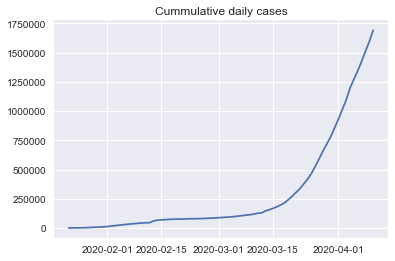

In [120]:
plt.plot(confirmed_cases_daily)
plt.title('Cummulative daily cases')

In [121]:
# we need to know the number of new cases daily without adding the first day cases
# we do the difference between each day and preserver the first day
confirmed_cases_daily = confirmed_cases_daily.diff().fillna(confirmed_cases_daily[0]).astype(np.int64)
confirmed_cases_daily.head()

2020-01-22    555
2020-01-23     99
2020-01-24    287
2020-01-25    493
2020-01-26    684
dtype: int64

Text(0.5, 1.0, 'Daily cases')

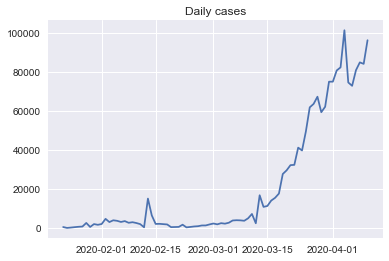

In [122]:
plt.plot(confirmed_cases_daily)
plt.title("Daily cases")

In [123]:
# check all the total number of dataset i.e all the days
confirmed_cases_daily.shape

(80,)

In [124]:
confirmed_cases_daily.to_csv('cleaned.csv', index=True)

C:\Users\taofe\Anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [125]:
df = pd.read_csv('cleaned.csv', names=['x', 'y'])

In [126]:
df.head()

,x,y
0,2020-01-22,555
1,2020-01-23,99
2,2020-01-24,287
3,2020-01-25,493
4,2020-01-26,684


In [127]:
X = df['x']
X

0     2020-01-22
1     2020-01-23
2     2020-01-24
3     2020-01-25
4     2020-01-26
         ...    
75    2020-04-06
76    2020-04-07
77    2020-04-08
78    2020-04-09
79    2020-04-10
Name: x, Length: 80, dtype: object

In [128]:
y = df['y']
y

0       555
1        99
2       287
3       493
4       684
      ...  
75    72986
76    80995
77    85008
78    84246
79    96369
Name: y, Length: 80, dtype: int64

In [129]:
# convert to numpy array
X = np.array([i for i in range(len(X))]).reshape(-1, 1)
y = np.array(y).reshape(-1, 1)

In [143]:
# Split the data into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, shuffle=False)

In [144]:
future_days = 10
future_prediction = np.array([i for i in range(len(X)+future_days)]).reshape(-1, 1)
adjusted_days = future_prediction[:-10]
future_prediction

array([[ 0],
       [ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12],
       [13],
       [14],
       [15],
       [16],
       [17],
       [18],
       [19],
       [20],
       [21],
       [22],
       [23],
       [24],
       [25],
       [26],
       [27],
       [28],
       [29],
       [30],
       [31],
       [32],
       [33],
       [34],
       [35],
       [36],
       [37],
       [38],
       [39],
       [40],
       [41],
       [42],
       [43],
       [44],
       [45],
       [46],
       [47],
       [48],
       [49],
       [50],
       [51],
       [52],
       [53],
       [54],
       [55],
       [56],
       [57],
       [58],
       [59],
       [60],
       [61],
       [62],
       [63],
       [64],
       [65],
       [66],
       [67],
       [68],
       [69],
       [70],
       [71],
       [72],
       [73],
       [74],
       [75],
       [76],

In [152]:
start = '22/1/2020'
start_date = datetime.datetime.strptime(start, '%d/%m/%Y')
future_prediction_dates = []
for i in range(len(future_prediction)):
    future_prediction_dates.append((start_date + datetime.timedelta(days=i)).strftime('%d/%m/%Y'))
future_prediction_dates

['22/01/2020',
 '23/01/2020',
 '24/01/2020',
 '25/01/2020',
 '26/01/2020',
 '27/01/2020',
 '28/01/2020',
 '29/01/2020',
 '30/01/2020',
 '31/01/2020',
 '01/02/2020',
 '02/02/2020',
 '03/02/2020',
 '04/02/2020',
 '05/02/2020',
 '06/02/2020',
 '07/02/2020',
 '08/02/2020',
 '09/02/2020',
 '10/02/2020',
 '11/02/2020',
 '12/02/2020',
 '13/02/2020',
 '14/02/2020',
 '15/02/2020',
 '16/02/2020',
 '17/02/2020',
 '18/02/2020',
 '19/02/2020',
 '20/02/2020',
 '21/02/2020',
 '22/02/2020',
 '23/02/2020',
 '24/02/2020',
 '25/02/2020',
 '26/02/2020',
 '27/02/2020',
 '28/02/2020',
 '29/02/2020',
 '01/03/2020',
 '02/03/2020',
 '03/03/2020',
 '04/03/2020',
 '05/03/2020',
 '06/03/2020',
 '07/03/2020',
 '08/03/2020',
 '09/03/2020',
 '10/03/2020',
 '11/03/2020',
 '12/03/2020',
 '13/03/2020',
 '14/03/2020',
 '15/03/2020',
 '16/03/2020',
 '17/03/2020',
 '18/03/2020',
 '19/03/2020',
 '20/03/2020',
 '21/03/2020',
 '22/03/2020',
 '23/03/2020',
 '24/03/2020',
 '25/03/2020',
 '26/03/2020',
 '27/03/2020',
 '28/03/20

In [145]:
# Model development
kernel = ['poly', 'sigmoid', 'rbf']
c = [0.01, 0.1, 1, 10]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
shrinking = [True, False]
svm_grid = {'kernel':kernel, 'C':c, 'gamma':gamma, 'epsilon':epsilon, 'shrinking':shrinking}

svm = SVR()
svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True,
                               n_jobs=-1, n_iter=40, verbose=1)
svm_search.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.5min finished
C:\Users\taofe\Anaconda3\envs\dev\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=40, n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1, 10],
                                        'epsilon': [0.01, 0.1, 1],
                                        'gamma': [0.01, 0.1, 1],
                                        'kernel': ['poly', 'sigmoid', 'rbf'],
                                        'shrinking': [True, False]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [146]:
svm_search.best_params_

{'shrinking': False, 'kernel': 'poly', 'gamma': 1, 'epsilon': 0.01, 'C': 10}

In [147]:
svm_cases = svm_search.best_estimator_
svm_predict = svm_cases.predict(future_prediction)
svm_cases, svm_predict

(SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.01, gamma=1,
     kernel='poly', max_iter=-1, shrinking=False, tol=0.001, verbose=False),
 array([   555.01000055,    555.19159398,    556.46274804,    559.91302337,
           566.6319805 ,    577.7091802 ,    594.23418315,    617.29654964,
           647.98584016,    687.39161714,    736.60343774,    796.71086534,
           868.80346139,    953.97078164,   1053.30239328,   1167.88785394,
          1298.81671746,   1447.17856439,   1614.06293328,   1800.55939325,
          2007.7574981 ,   2236.74681695,   2488.61691888,   2764.45735772,
          3065.35768731,   3392.40746148,   3746.69624932,   4129.31365045,
          4541.34914239,   4983.89235528,   5458.03282769,   5964.8600982 ,
          6505.4637359 ,   7080.93334039,   7692.35851129,   8340.82860406,
          9027.43346246,   9753.26244195,  10519.40514215,  11326.95116266,
         12176.98998101,  13070.61131891,  14008.9045318 ,  14992.95946344,
         16023.8

Mean Squared error: 150934139.89964092
Mean Absolute error: 8938.827520795066


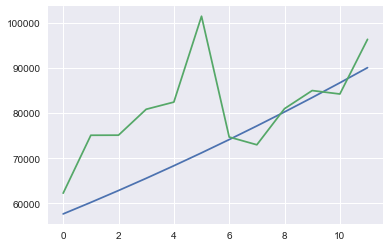

In [148]:
svm_test_predict = svm_cases.predict(X_test)
plt.plot(svm_test_predict)
plt.plot(y_test)

print(f'Mean Squared error: {mean_squared_error(svm_test_predict, y_test)}')
print(f'Mean Absolute error: {mean_absolute_error(svm_test_predict, y_test)}')

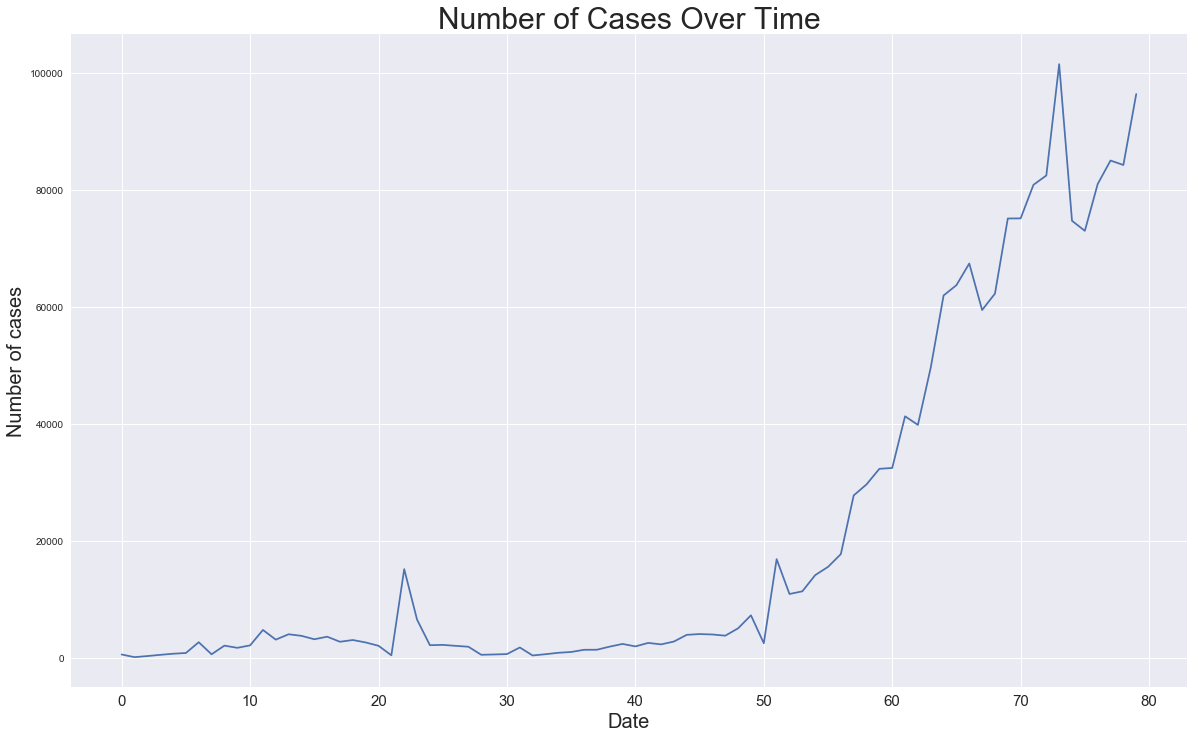

In [149]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_days, y)
plt.title('Number of Cases Over Time', size=30)
plt.xlabel('Date', size=20)
plt.ylabel('Number of cases', size=20)
plt.xticks(size=15)
plt.show()

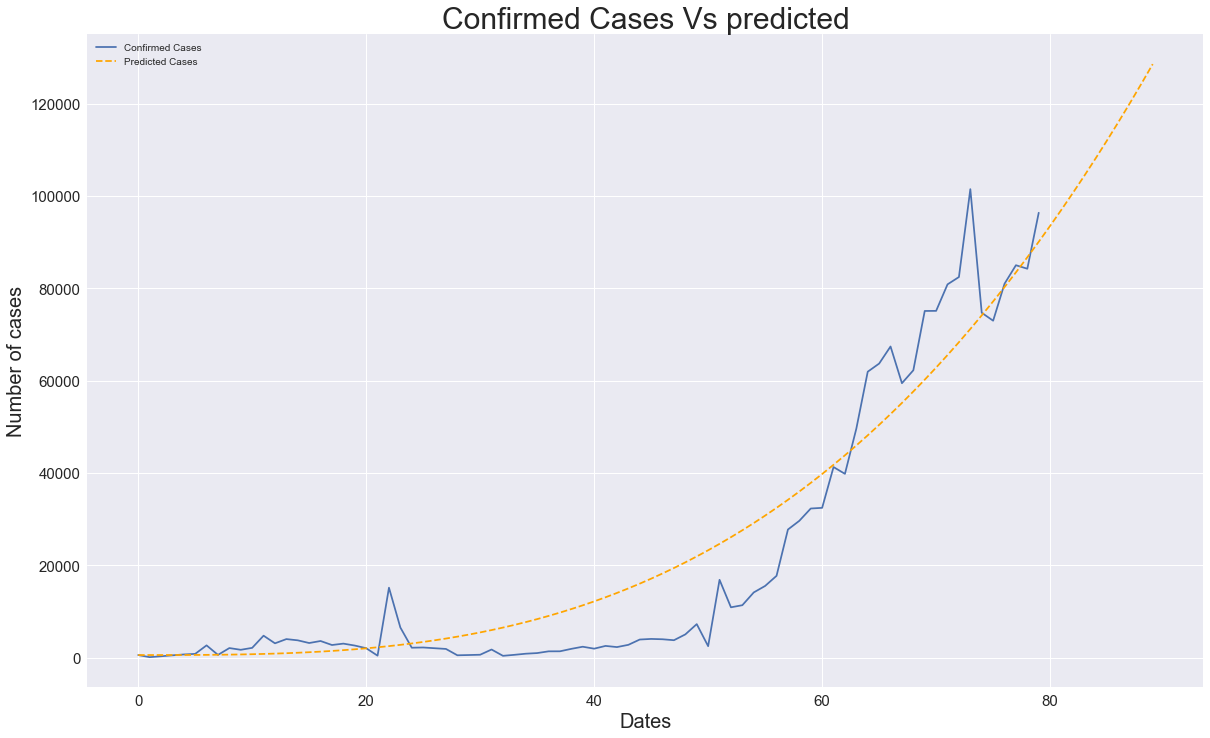

In [150]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_days, y)
plt.plot(future_prediction, svm_predict, linestyle='dashed', color='orange')
plt.title('Confirmed Cases Vs predicted', size=30)
plt.xlabel('Dates', size=20)
plt.ylabel('Number of cases', size=20)
plt.legend(['Confirmed Cases', 'Predicted Cases'])
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

In [153]:
print('Future Predictions in the (Next 10 days)')
set(zip(future_prediction_dates[-10:], svm_predict[-10:]))

Future Predictions in the (Next 10 days)


{('11/04/2020', 93530.84984429568),
 ('12/04/2020', 97061.20824273318),
 ('13/04/2020', 100679.82054742068),
 ('14/04/2020', 104387.77660210818),
 ('15/04/2020', 108186.16625054568),
 ('16/04/2020', 112076.08031304568),
 ('17/04/2020', 116058.60570367068),
 ('18/04/2020', 120134.83324273318),
 ('19/04/2020', 124305.85277398318),
 ('20/04/2020', 128572.75414117068)}

In [159]:
# Use Linear Regression
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression(normalize=True, fit_intercept=True)
linear_model.fit(X_train, y_train)
predict = linear_model.predict(X_test)
predictions = linear_model.predict(future_prediction)

print('Mean Squared error', mean_squared_error(predict, y_test))
print('Mean Absolute error', mean_absolute_error(predict, y_test))

Mean Squared error 2209082537.159543
Mean Absolute error 46127.65839281852


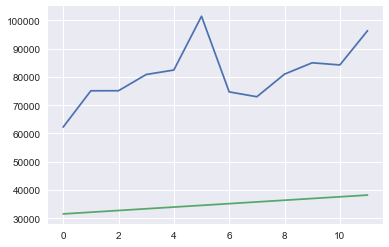

In [160]:
plt.plot(y_test)
plt.plot(predict)

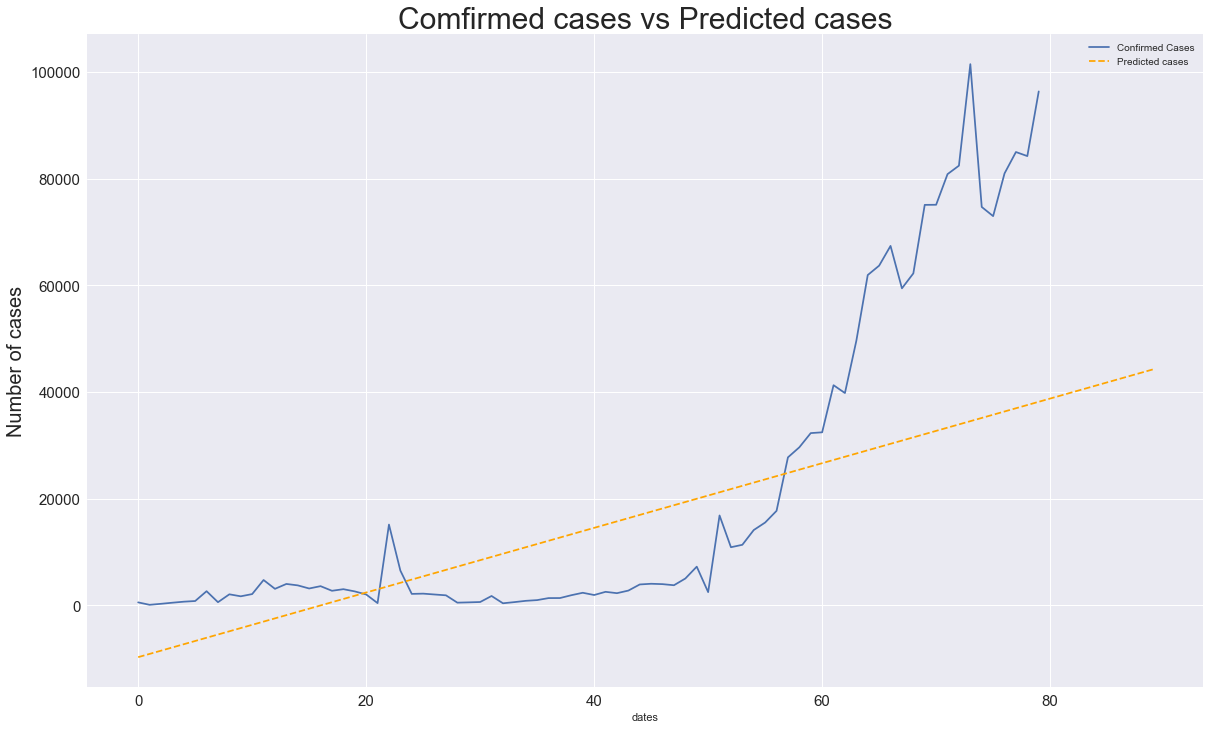

In [162]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_days, y)
plt.plot(future_prediction, predictions, linestyle='dashed', color='orange')
plt.title('Comfirmed cases vs Predicted cases', size=30)
plt.xlabel('dates')
plt.ylabel('Number of cases', size=20)
plt.legend(['Confirmed Cases', 'Predicted cases'])
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

In [167]:
# Create a submission DataFrame
sub = pd.DataFrame({'Region X Date':future_prediction_dates[-10:],'target':svm_predict[-10:]})
sub.to_csv('submission.scv', index=False)

In [168]:
check = pd.read_csv('submission.scv')
check.head()

,Region X Date,target
0,11/04/2020,93530.849844
1,12/04/2020,97061.208243
2,13/04/2020,100679.820547
3,14/04/2020,104387.776602
4,15/04/2020,108186.166251
